# Targets

Specify the **`x,y,z`** coordination, **`sphere size`** and **`intensity`** of the clusters that you want to simulate.

In [6]:
# Target: Location, radius, intensity
target = [([150, 105, 80], 20, 1.),
          ([30, 105, 80], 25, -1.),
          ([65, 30, 75], 30, -1.2),
          ([115, 30, 75], 30, 1.2)]

# Create Fake Dataset

### Import python modules

In [7]:
%pylab inline
import numpy as np
import nibabel as nb
from nilearn.plotting import plot_stat_map, plot_glass_brain, cm
from nilearn.image import smooth_img
from scipy.stats import zscore

Populating the interactive namespace from numpy and matplotlib


###  Create dataset, insert target spheres and add some noise

In [54]:
# Load MNI152 template mask
mask = nb.load('templates/MNI152_T1_1mm_brain_mask.nii.gz')

# Create empty dataset
data = np.array(mask.get_data().copy() * 0, dtype='float')

# Add noise to dataset
data += np.random.normal(loc=1., scale=2., size=data.shape)

# Go through all the targets
for t in target:

    # Create noisy sphere
    radius = t[1]
    r2 = np.arange(-radius, radius + 1)**2
    r2 = -(r2 - r2.max())
    dist = np.asarray(r2[:, None, None] + r2[:, None] + r2, dtype='float')
    dist -= dist[0].max()
    dist[dist <= 0] = 0
    dist /= dist.max()
    dist *= np.random.normal(loc=2.0, scale=2.5, size=dist.shape) * t[2]

    # Add noisy sphere to dataset
    c = t[0]
    data[c[0] - radius:c[0] + radius + 1,
         c[1] - radius:c[1] + radius + 1,
         c[2] - radius:c[2] + radius + 1] += dist

# zscore data
data = zscore(data)

# Create NIfTI dataset
img = nb.Nifti1Image(data, mask.affine, mask.header)

# Smooth dataset
fwhm = 6
img = smooth_img(img, fwhm)

# Mask brain
data = img.get_data()
data *= mask.get_data()

# Threshold data and rescale it
data /= np.abs(data).max()
data[np.abs(data) <= np.percentile(np.abs(data), 99.5)] = 0
tmp = np.abs(data) - np.abs(data[data != 0]).min()
tmp[tmp <= 0] = 0
tmp /= tmp.max()
data = tmp * np.sign(data)

# Save Dataset
img = nb.Nifti1Image(data, img.affine, img.header)
nb.save(img, 'res.nii.gz')

# Visualize Results

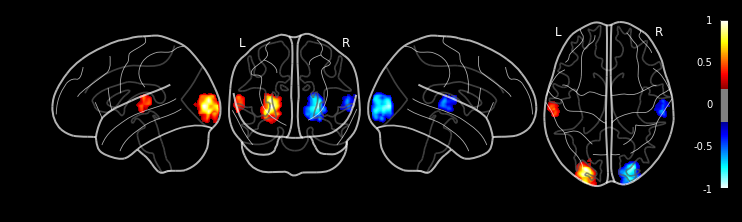

In [10]:
plot_glass_brain('res.nii.gz', threshold=0.2, display_mode='lyrz',
                 black_bg=True, plot_abs=False, colorbar=True, cmap=cm.cold_hot)

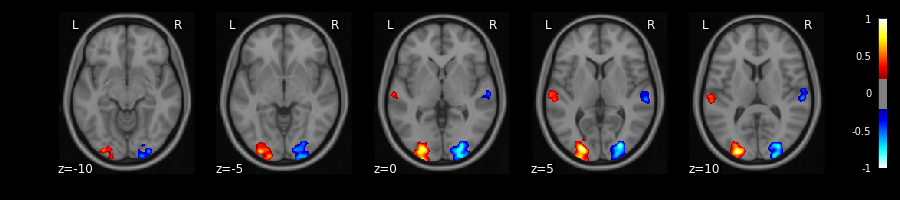

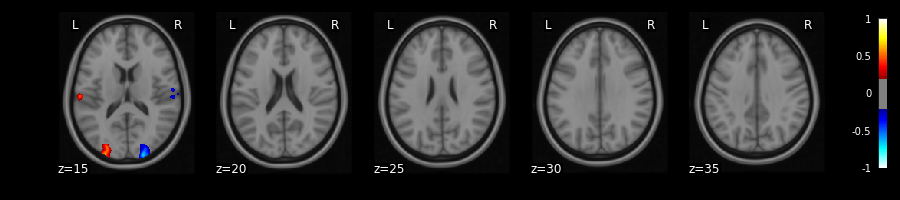

In [11]:
anatimg = 'templates/MNI152_T1_1mm.nii.gz'
plot_stat_map('res.nii.gz', cut_coords=(-10, -5, 0, 5, 10),
              bg_img=anatimg, threshold=0.2, display_mode='z', cmap=cm.cold_hot)
plot_stat_map('res.nii.gz', cut_coords=(15, 20, 25, 30, 35),
              bg_img=anatimg, threshold=0.2, display_mode='z', cmap=cm.cold_hot)


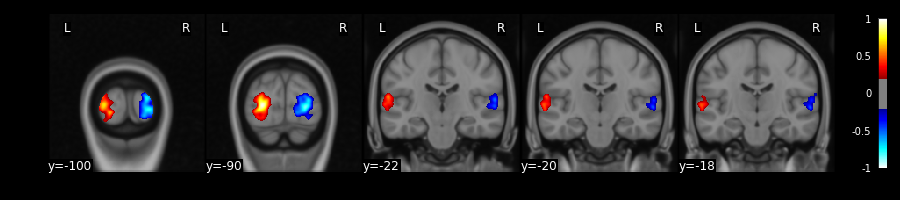

In [12]:
anatimg = 'templates/MNI152_T1_1mm.nii.gz'
plot_stat_map('res.nii.gz', cut_coords=(-100, -90, -22, -20, -18),
              bg_img=anatimg, threshold=0.2, display_mode='y', cmap=cm.cold_hot)


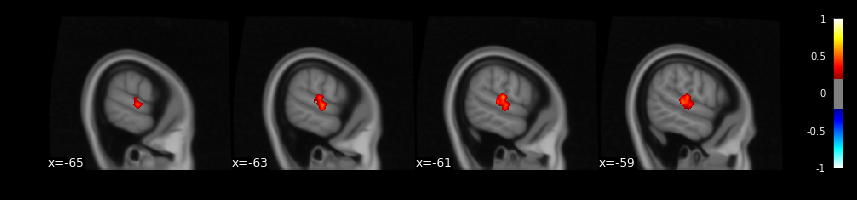

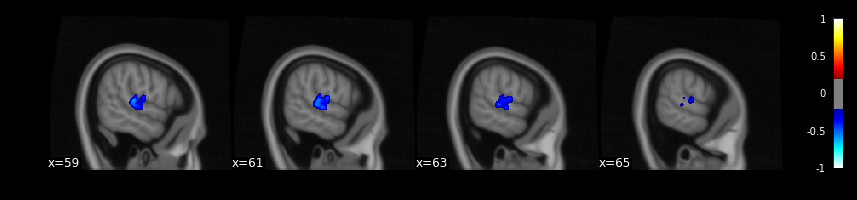

In [13]:
plot_stat_map('res.nii.gz', cut_coords=(-65, -63, -61, -59),
              bg_img=anatimg, threshold=0.2, display_mode='x', cmap=cm.cold_hot)
plot_stat_map('res.nii.gz', cut_coords=(59, 61, 63, 65),
              bg_img=anatimg, threshold=0.2, display_mode='x', cmap=cm.cold_hot)


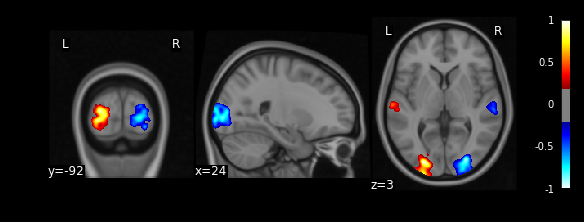

In [14]:
plot_stat_map('res.nii.gz', bg_img=anatimg, threshold=0.2,
              display_mode='ortho', draw_cross=False, cmap=cm.cold_hot)


# Extract Cluster Information

In [63]:
from scipy.ndimage import label
labels, nlabels = label(img.get_data())

for i in range(nlabels):
    cSize = (labels == i + 1).sum()
    maxcoord = np.abs(data) == np.abs(data[labels == i + 1]).max()
    cPeak = np.round(data[maxcoord][0], 3)
    print 'Cluster %.2d: Size = %s voxels, Peak Value: %s' % (i + 1, cSize, cPeak)
    coord = np.dot(img.affine, np.hstack(
        (np.ravel(np.where(maxcoord)), 1)))[:3].tolist()
    coordStr = ','.join([str(coord[0]), str(coord[1]), str(coord[2])])
    %run atlas_reader.py all $coordStr 0 1


Cluster 01: Size = 4649 voxels, Peak Value: -0.612
Segmentation information at [63.0, -21.0, 11.0]:
HarvardOxford                   57% Planum_Temporale
HarvardOxford                    7% Parietal_Operculum_Cortex
HarvardOxford                    4% Superior_Temporal_Gyrus_posterior_division
HarvardOxford                    3% Central_Opercular_Cortex
HarvardOxford                    2% Heschl's_Gyrus_(includes_H1_and_H2)
HarvardOxford                    1% Supramarginal_Gyrus_anterior_division
Juelich                         10% GM_Secondary_somatosensory_cortex_/_Parietal_operculum_OP1_R


Cluster 02: Size = 14266 voxels, Peak Value: -0.855
Segmentation information at [28.0, -94.0, 13.0]:
HarvardOxford                   52% Occipital_Pole
HarvardOxford                    7% Lateral_Occipital_Cortex_superior_division
Juelich                         40% GM_Visual_cortex_V2_BA18_R
Juelich                         10% GM_Visual_cortex_V1_BA17_R


Cluster 03: Size = 13576 voxels, Peak Val